In [1]:
# import libraries
import pandas as pd
import numpy as np
import timeit

from statistics import median, mean

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

pd.set_option('display.max_rows', 90000)
pd.set_option('display.max_columns', 50)

In [2]:
path = '/Users/nikhilsawal/OneDrive/machine_learning/data_science_case_studies/buildzoom/data/'

train_x = pd.read_table(path + 'train_data.csv')
test_x = pd.read_table(path + 'xtest_data.csv')
test_y = pd.read_csv(path + 'ytest_pred.csv')

## License Type

In [3]:
import re

def get_uniques(df, col_name):
    
    """Any instance of the license type may contain duplicate!! For example:
    the GENERAL CONTRACTOR LICENSE may appear twice, but in reality doesn't 
    add any value to our model and need to be removed."""
    
    uniques = []
    for i in df[col_name]:
        uniques += i
    return list(set(uniques))


def get_pattern(df):
    
    """
    This function identifies all the different possible appearances 
    for a license type. For example: GENERAL CONTRACTOR LICENSE has the 
    following appearances:
    >>> ['GENERAL CO', 'GENERAL C', 'GENERA',
        'GENERAL CONTRACTOR LICENSE', 'GENERAL ', 'GENERAL CONT', 
        'GENERAL CONTRA', 'GENERAL']
    """
    
    uniques = get_uniques(df, 'licensetype')
    unique = []
    for i in range(len(uniques)):
        
        pattern = re.compile('^'+uniques[i][:5]+'*')
        matches = []
        for index, license in enumerate(uniques):

            if pattern.search(license) is not None:
                matches.append(license)
        
        if matches not in unique:
            unique.append(matches)
        pass
    
    licenseList = []
    licenseDict = {}
    
    for licenses in unique:
        licenseList.append(licenses)
        licenseDict[max(licenses)] = licenses
    
    return licenseList
  

# Clean licensetype
def clean_license(inp_list, pattern):
    
    """
    This function takes a list of patterns generated by the get_pattern()
    function and replaces any unusual license type by the more general!!!
    For example: ['GENERAL CO', 'GENERAL C', 'GENERA',
                  'GENERAL CONTRACTOR LICENSE', 'GENERAL ', 
                  'GENERAL CONT', 'GENERAL CONTRA', 'GENERAL']
        
    will be replaces with 'GENERAL CONTRACTOR LICENSE'
    """
    
    temp_list = []
    for i in inp_list:
        if i == 'None':
            temp_list.append(i)
        else:
            for j in pattern:
                temp = []
                if i in j:
                    temp_list.append(max(j).lower().replace(" ", "_"))
                    break
    return temp_list



In [4]:
start = timeit.default_timer()
train_x.loc[:,'licensetype'] = train_x.loc[:,'licensetype'].fillna('None')
train_x.loc[:,'licensetype'] = train_x.loc[:,'licensetype'].apply(lambda x: x.split(', ')).apply(lambda x: list(set(x)))
pattern = get_pattern(train_x)
stop = timeit.default_timer()
print('Get Pattern: ', stop - start)


start = timeit.default_timer()
cleaned_license = [clean_license(item, pattern) for item in train_x['licensetype']]
cleaned_license = ['-'.join(sorted(i)) for i in cleaned_license]
train_x.loc[:,'licensetype'] = cleaned_license
stop = timeit.default_timer()
print('Clean License: ', stop - start)

Get Pattern:  0.20685608500000008
Clean License:  0.16768215300000122


## businessname

In [5]:
def get_businessname(data, n):
    """Set top N businessnames as factor"""
    temp = data['businessname'].value_counts().head(n).index.values
    top_n = [i.lower().replace(" ","_") if i in temp else 'Other' for i in data['businessname']]
    return top_n

In [6]:
start = timeit.default_timer()
train_x['businessname'].fillna('None', inplace=True)
train_x.loc[:,'businessname'] = get_businessname(train_x, 100)
stop = timeit.default_timer()
print('Business Name: ', stop - start)


Business Name:  0.6141119450000012


## description

In [7]:
# Remove stopwords, non alphabetic characters

def nltk_description(data):
    
    """
    This function takes in text data in the form of description
    which is first tokenized and later cleaned by removing all stopwords,
    removing special characters, stemming each character to its root form
    and returns a string.
    """
    
    stop_words = set(stopwords.words("english"))
    ps = PorterStemmer()
    num_pattern = re.compile(r'\s*[\W0-9\s]\s*')

    sample = []

    for index, description in enumerate(data["description"]):
        
        words = word_tokenize(description)
        no_stops = [i for i in words if i.lower() not in stop_words]
        no_special_char = [ps.stem(num_pattern.sub("",i)) for i in no_stops if ps.stem(num_pattern.sub("",i)) != '']
        descrip = " ".join(i for i in no_special_char)
        sample.append(descrip)
    
    return sample


In [8]:
start = timeit.default_timer()
train_x.loc[:,'description'] = train_x.loc[:,'description'].fillna('None')
train_x.loc[:,'description'] = nltk_description(train_x)
stop = timeit.default_timer()
print('Description: ', stop - start)



Description:  46.411181537000004


## subtype

In [9]:
def encode_subtype(data):
    """Encode subtype using OneHotEncoding"""
    data.loc[:,'subtype'] = data.loc[:,'subtype'].fillna('None')
    z = data.loc[:,['subtype']].values
    y = OneHotEncoder().fit_transform(z).toarray()
    return y

In [10]:
start = timeit.default_timer()
train_x['subtype'] = train_x['subtype'].fillna('None')
train_x['subtype'] = [i.lower().replace(" ", "_") for i in train_x['subtype']]
stop = timeit.default_timer()
print('Subtype: ', stop - start)



Subtype:  0.0484910119999995


## Data Preparation

In [11]:
def data_preprocessing(data):

    # license type 
    data.loc[:,'licensetype'] = data.loc[:,'licensetype'].fillna('None')
    data.loc[:,'licensetype'] = data.loc[:,'licensetype'].apply(lambda x: x.split(', ')).apply(lambda x: list(set(x)))
      
    pattern = get_pattern(data)
    cleaned_license = [clean_license(item, pattern) for item in data['licensetype']]
    cleaned_license = ['-'.join(sorted(i)) for i in cleaned_license]
    data.loc[:,'licensetype'] = cleaned_license
    
    # Set top business names as factors
    data['businessname'].fillna('None', inplace=True)
    data.loc[:,'businessname'] = get_businessname(data, 100)
    
    # Set binary value for legal description
    data.loc[:,'legaldescription'] = data['legaldescription'].fillna('None')
    data.loc[:,'has_ld'] = [1 if i!='None' else 0 for i in data['legaldescription']]
    
    # tfidf for description
    data.loc[:,'description'] = data.loc[:,'description'].fillna('None')
    data.loc[:,'description'] = nltk_description(data)
    
    # Subtype
    data['subtype'] = data['subtype'].fillna('None')
    data['subtype'] = [i.lower().replace(" ", "_") for i in data['subtype']]

    # Job Value
    cleaned_job_value = data['job_value'].apply(lambda x: float(str(x).replace('$', '').replace(',','')))
    data.loc[:,'job_value'] = cleaned_job_value
    data.loc[:,'job_value'] = data['job_value'].fillna(0.0)
    
    return data.loc[:, ~data.columns.isin(['legaldescription'])]


    

In [12]:
start = timeit.default_timer()
data_preprocessing(train_x)
stop = timeit.default_timer()
print('Data preprocessing: ', stop - start)



Data preprocessing:  40.12010430800001


In [13]:
start = timeit.default_timer()
del(train_x)
del(test_x)
del(test_y)

train_x = pd.read_table(path + 'train_data.csv')
test_x = pd.read_table(path + 'xtest_data.csv')
test_y = pd.read_csv(path + 'ytest_pred.csv')

X = train_x.loc[:,~train_x.columns.isin(['type'])].copy()
y = train_x['type'].apply(lambda x: 1 if x=='ELECTRICAL' else 0) 
X_test = test_x.copy()
y_test = test_y

X = data_preprocessing(X)
X_test = data_preprocessing(X_test)

stop = timeit.default_timer()
print('Train - Test data prep: ', stop - start)



Train - Test data prep:  58.90312332699999


## Train ML model

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


def machine_learning_prep(train_X, train_y, test_X, test_y):
    
    # Prep training data
    X = train_X.values
    y = train_y.values
    X_test = test_X.iloc[:25148,:].values
    y_test = test_y.values
    
    # Train Validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size=0.25, 
                                                      random_state=1, 
                                                      stratify=y)
    
    print("Make sure stratification works and we have equal split across train-val-test sets")
    print("Train split: ", y_train.sum()/len(y_train))
    print("Validation split: ", y_val.sum()/len(y_val))
    print("Test split: ", y_test.sum()/len(y_test))
    print("\n")
    
    # Transform licensetype, businessname and subtype using OneHotEncoding
    column_trans = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 1, 3]),
                                           remainder='passthrough')
    
    X_train = column_trans.fit_transform(X_train)
    X_val = column_trans.transform(X_val)
    X_test = column_trans.transform(X_test)
    
    
    # Transform Description using tf-idf
    tf = TfidfVectorizer(min_df=1, stop_words='english', lowercase=False)
    X_train[:,-3] = tf.fit_transform(X_train[:,-3]).toarray().sum(axis=1)
    X_val[:,-3] = tf.transform(X_val[:,-3]).toarray().sum(axis=1)
    X_test[:,-3] = tf.transform(X_test[:,-3]).toarray().sum(axis=1)

    
    # Training model with XGBoost
    classifier = XGBClassifier(objective='binary:logistic', 
                               use_label_encoder=False,
                               subsample=0.9,
                               colsample_bytree=0.2,
                               seed=10)
    
    model = classifier.fit(X_train, 
                           y_train,
                           early_stopping_rounds=10,
                           verbose=True,
                           eval_metric='aucpr',
                           eval_set=[(X_val, y_val)])
    
    # Plot confusion matrix for validation set
    plot_confusion_matrix(classifier,
                          X_val,
                          y_val,
                          values_format='d',
                          display_labels=["NON ELECTRICAL TYPE", 
                                          "ELECTRICAL TYPE"])
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(classifier,
                          X_test,
                          y_test,
                          values_format='d',
                          display_labels=["NON ELECTRICAL TYPE", 
                                          "ELECTRICAL TYPE"])
    
    # Evaluating Model
    y_pred = classifier.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    
    # Evaluating model on test
    y_test_pred = classifier.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return cm, accuracy, cm_test, accuracy_test
    

# Baseline Model

Make sure stratification works and we have equal split across train-val-test sets
Train split:  0.28604709985755555
Validation split:  0.28603378729182477
Test split:  0.2755686336885637


[0]	validation_0-aucpr:0.34689
[1]	validation_0-aucpr:0.67387
[2]	validation_0-aucpr:0.76348
[3]	validation_0-aucpr:0.88144
[4]	validation_0-aucpr:0.89264
[5]	validation_0-aucpr:0.91056
[6]	validation_0-aucpr:0.91327
[7]	validation_0-aucpr:0.91450
[8]	validation_0-aucpr:0.91823
[9]	validation_0-aucpr:0.92568
[10]	validation_0-aucpr:0.92962
[11]	validation_0-aucpr:0.93248
[12]	validation_0-aucpr:0.93977
[13]	validation_0-aucpr:0.93865
[14]	validation_0-aucpr:0.94189
[15]	validation_0-aucpr:0.94399
[16]	validation_0-aucpr:0.94506
[17]	validation_0-aucpr:0.94844
[18]	validation_0-aucpr:0.95324
[19]	validation_0-aucpr:0.95593
[20]	validation_0-aucpr:0.95635
[21]	validation_0-aucpr:0.95849
[22]	validation_0-aucpr:0.95957
[23]	validation_0-aucpr:0.96328
[24]	validation_0-aucpr:0.96596
[25]	validation_0-auc

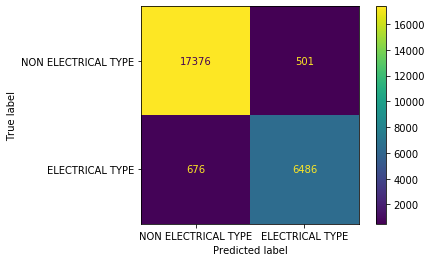

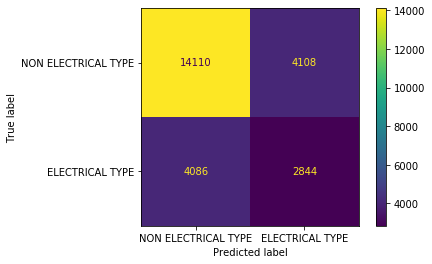

In [15]:
start = timeit.default_timer()
cm, accuracy, cm_test, accuracy_test = machine_learning_prep(X, y, X_test, y_test)
print('\n')
print('Validation Accuracy')
print(cm, '\n', accuracy, '\n')
print('Test Accuracy')
print(cm_test, '\n', accuracy_test)

stop = timeit.default_timer()
print('\n')
print('Baseline Model Training: ', stop - start)


# Optimize parameters using Cross validation and GridSearch()

In [19]:
# # ROUND 1
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5]
# }

# # ROUND 2
# param_grid = {
#     'max_depth': [5, 6, 7],
#     'learning_rate': [1, 0.5, 0.1],
#     'gamma': [0.25],
#     'reg_lambda': [0],
#     'scale_pos_weight': [3]
# }

# ROUND 3
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.5],
    'gamma': [0.25],
    'reg_lambda': [0],
    'scale_pos_weight': [3]
}



In [17]:
# Prep training data
X = X.values
y = y.values
X_test = X_test.iloc[:25148,:].values
y_test = y_test.values
    
# Train Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25, 
                                                  random_state=1, 
                                                  stratify=y)

# Transform licensetype, businessname and subtype using OneHotEncoding
column_trans = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 1, 3]),
                                        remainder='passthrough')
    
X_train = column_trans.fit_transform(X_train)
X_val = column_trans.transform(X_val)
X_test = column_trans.transform(X_test)
    
    
# Transform Description using tf-idf
tf = TfidfVectorizer(min_df=1, stop_words='english', lowercase=False)
X_train[:,-3] = tf.fit_transform(X_train[:,-3]).toarray().sum(axis=1)
X_val[:,-3] = tf.transform(X_val[:,-3]).toarray().sum(axis=1)
X_test[:,-3] = tf.transform(X_test[:,-3]).toarray().sum(axis=1)



In [20]:
start = timeit.default_timer()
    
# Training model with XGBoost
classifier = XGBClassifier(objective='binary:logistic', 
                           use_label_encoder=False,
                           subsample=0.7,
                           colsample_bytree=0.5,
                           seed=10)

optimal_params = GridSearchCV(
    estimator = classifier,
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train)
best_accuracy = optimal_params.best_score_
best_parameters = optimal_params.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters: ", best_parameters)

stop = timeit.default_timer()
print('\n')
print('Baseline Model Training: ', stop - start)


[13:59:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy: 99.22 %
Best Parameters:  {'gamma': 0.25, 'learning_rate': 0.5, 'max_depth': 6, 'reg_lambda': 0, 'scale_pos_weight': 3}


Baseline Model Training:  17.668954616999997


Validation accuracy:  0.9457246695155558
Test accuracy:  0.6522188643232066


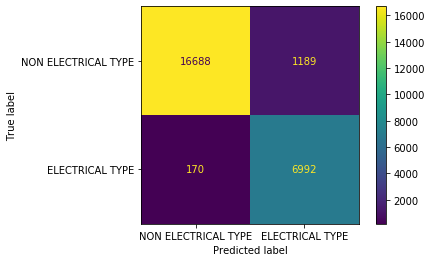

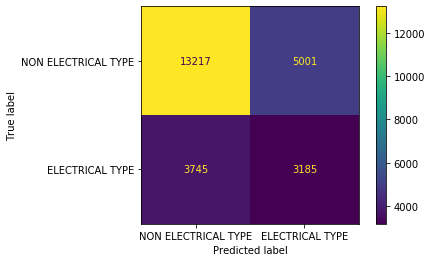

In [21]:
# Training model with XGBoost optimized parameters
classifier = XGBClassifier(objective='binary:logistic',
                           gamma=0.25,
                           learning_rate=0.5,
                           max_depth=6,
                           reg_alpha=1.0,
                           scale_pos_weight=3,
                           use_label_encoder=False,
                           subsample=0.9,
                           colsample_bytree=0.5,
                           seed=10)
    
model = classifier.fit(X_train, 
                       y_train,
                       early_stopping_rounds=10,
                       verbose=False,
                       eval_metric='aucpr',
                       eval_set=[(X_val, y_val)])

# Plot confusion matrix for validation set
plot_confusion_matrix(classifier,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["NON ELECTRICAL TYPE", 
                                      "ELECTRICAL TYPE"])


    
# Plot confusion matrix for test set
plot_confusion_matrix(classifier,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["NON ELECTRICAL TYPE", 
                                      "ELECTRICAL TYPE"])

# Evaluating Model
y_pred = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
print("Validation accuracy: ", accuracy)
    
# Evaluating model on test
y_test_pred = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test accuracy: ", accuracy_test)

# References

1. [StatQuest](https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2217s)
2. [Data School](https://www.youtube.com/watch?v=irHhDMbw3xo&t=135s)

# Tutorial

In [ ]:
import sys
!{sys.executable} -m pip install xgboost